<a href="https://colab.research.google.com/github/gawaresumit/-NewOne/blob/main/Modeling_Synthetic_Climate_Variations_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

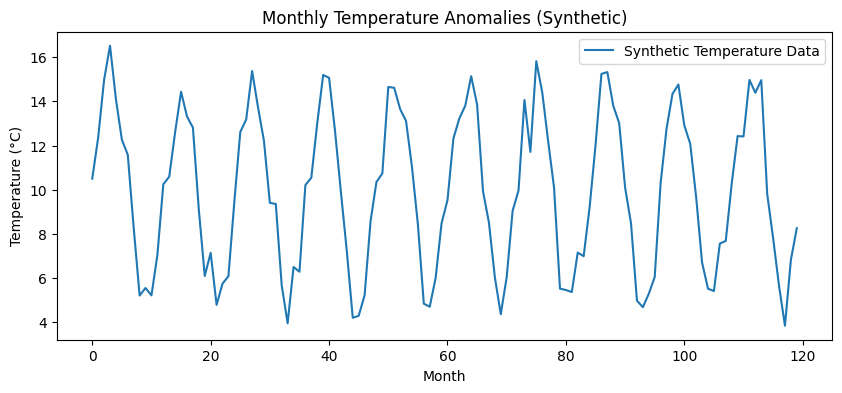

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Reproducibility
np.random.seed(42)

# Generate synthetic monthly temperature data (10 years)
months = np.arange(0, 10 * 12)
temperature = 10 + 5 * np.sin(2 * np.pi * months / 12) + np.random.randn(len(months))

plt.figure(figsize=(10, 4))
plt.plot(months, temperature, label="Synthetic Temperature Data")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.title("Monthly Temperature Anomalies (Synthetic)")
plt.legend()
plt.show()


# Prepare Input–Output Windows (12 months → next month)

In [ ]:
def create_windows(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_windows(temperature)

print("Input shape:", X.shape)
print("Output shape:", y.shape)


Input shape: (108, 12)
Output shape: (108,)


# Define a Feedforward Neural Network

# A simple network with one hidden layer and ReLU activation.

In [ ]:
class TempPredictor(nn.Module):
    def __init__(self):
        super(TempPredictor, self).__init__()
        self.fc1 = nn.Linear(12, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = TempPredictor()
print(model)


TempPredictor(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


# Train the Model

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().reshape(-1, 1)

epochs = 200
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()         # Autograd in action!
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [20/200], Loss: 10.1255
Epoch [40/200], Loss: 1.9625
Epoch [60/200], Loss: 1.2303
Epoch [80/200], Loss: 1.1812
Epoch [100/200], Loss: 1.1524
Epoch [120/200], Loss: 1.1389
Epoch [140/200], Loss: 1.1269
Epoch [160/200], Loss: 1.1148
Epoch [180/200], Loss: 1.1026
Epoch [200/200], Loss: 1.0907


# Plot Training Loss and Predictions

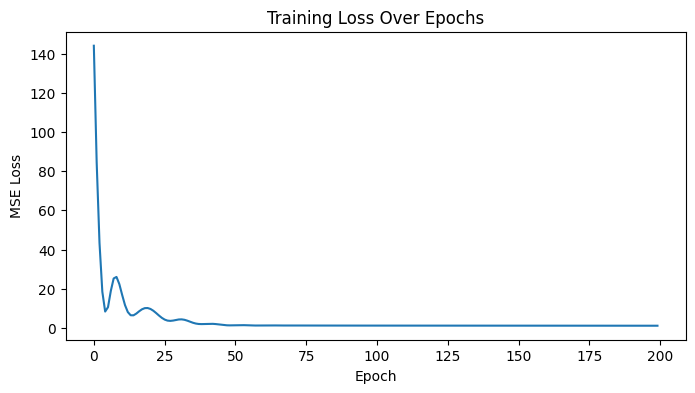

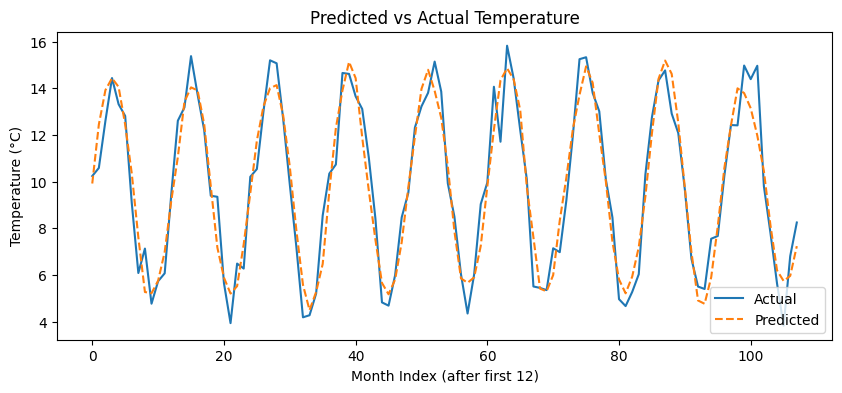

In [ ]:
# Training loss trend
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# Compare predicted vs actual values
predicted = model(X_tensor).detach().numpy()

plt.figure(figsize=(10,4))
plt.plot(y, label="Actual")
plt.plot(predicted, label="Predicted", linestyle="--")
plt.title("Predicted vs Actual Temperature")
plt.xlabel("Month Index (after first 12)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


# Inspect Autograd Behavior (Gradients)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - Gradient mean: {param.grad.mean():.6f}")


fc1.weight - Gradient mean: -0.000074
fc1.bias - Gradient mean: -0.000495
fc2.weight - Gradient mean: -0.007088
fc2.bias - Gradient mean: -0.012319


#### What role does autograd play in updating model weights?

####Autograd automatically computes the gradients of loss with respect to model parameters (weights and biases).
#### These gradients are then used by the optimizer (e.g., Adam) to update weights in the direction that minimizes loss.
#### Without autograd, you’d have to manually derive and implement gradient formulas — which is error-prone and tedious.

#### 2️⃣ How does the choice of learning rate affect model convergence?

####Too high → Model may overshoot minima, loss may oscillate or diverge.
#### Too low → Model converges very slowly or gets stuck in local minima.

#### Optimal range (e.g., 0.001–0.01 for Adam) → Smooth and steady convergence.

#### 3️⃣ If you remove loss.backward() step, what happens to training?

#### Without loss.backward(), gradients are never computed, so .step() has no information to update model weights.
#### The model will never learn — loss will remain constant, and predictions won’t improve.